In [ ]:
# Source : https://towardsdatascience.com/patchtst-a-breakthrough-in-time-series-forecasting-e02d48869ccc

In [95]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, PatchTST

from neuralforecast.losses.pytorch import MAE
from neuralforecast.losses.numpy import mae, mse

from datasetsforecast.long_horizon import LongHorizon

from sklearn.preprocessing import RobustScaler

In [145]:
df = pd.read_csv('../prepared_data/01_06_2021_to_20_06_2023_filtered_435.csv', parse_dates=['date'])
df = df.rename(columns={'date': 'ds', 'nb_bookings':'y'})

In [146]:
df = df.drop(['nb_cars_cxl', 'nb_cars', 'nb_bookings_cxl'], axis=1)

In [147]:
df['unique_id'] = 1

In [148]:
df.head()

,ds,y,unique_id
0,2021-06-01,7,1
1,2021-06-02,13,1
2,2021-06-03,10,1
3,2021-06-04,45,1
4,2021-06-05,10,1


In [149]:
robust_scaler = RobustScaler()
df['y'] = robust_scaler.fit_transform(df['y'].values.reshape(-1, 1))

In [150]:
val_size_pk = 75
test_size_pk = 150
n_time_pk = 750

print(val_size_pk, test_size_pk)

75 150


0     2021-06-01
1     2021-06-02
2     2021-06-03
3     2021-06-04
4     2021-06-05
         ...    
745   2023-06-16
746   2023-06-17
747   2023-06-18
748   2023-06-19
749   2023-06-20
Name: ds, Length: 750, dtype: datetime64[ns]


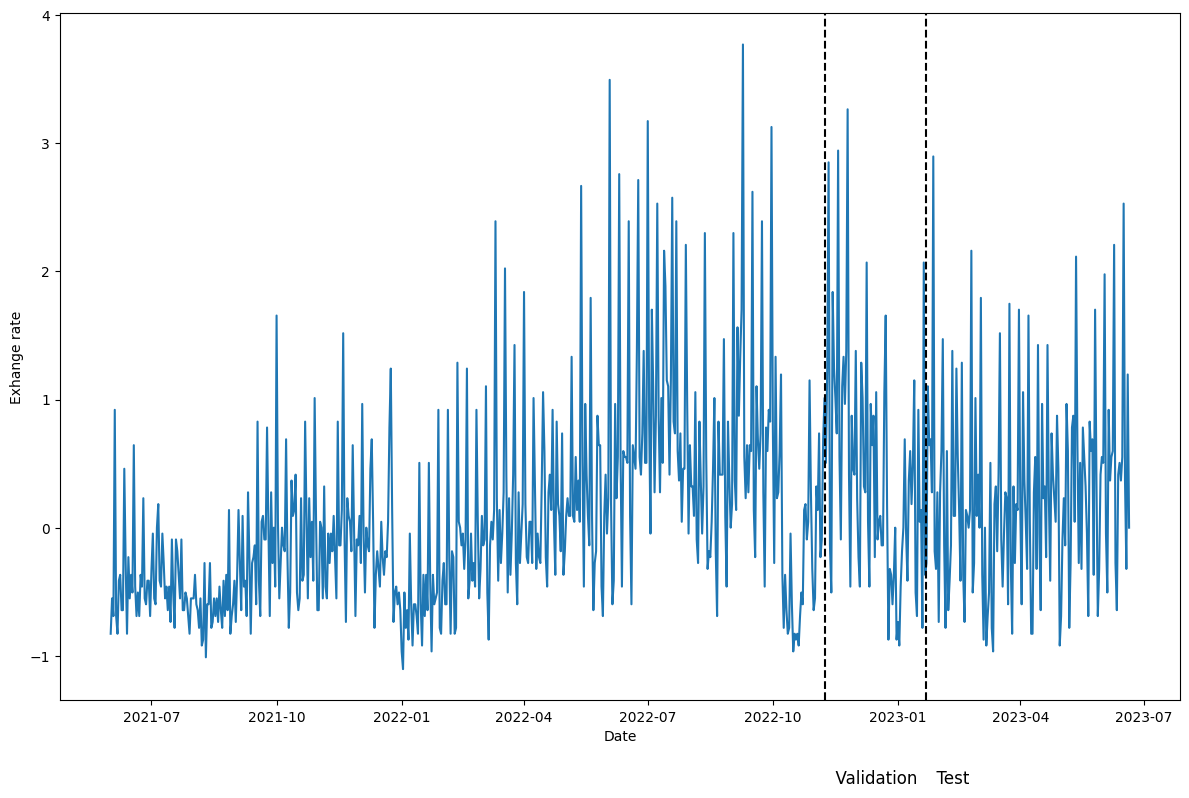

In [151]:
u_id = '1'

x_plot = df['ds']
y_plot = df['y']

print(x_plot)


x_val = x_plot[n_time_pk - val_size_pk - test_size_pk]
x_test = x_plot[n_time_pk - test_size_pk]

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x_plot, y_plot)
ax.set_xlabel('Date')
ax.set_ylabel('Exhange rate')
ax.axvline(x_val, color='black', linestyle='--')
ax.axvline(x_test, color='black', linestyle='--')

plt.text(x_val, -2, '  Validation', fontsize=12)
plt.text(x_test,-2, '  Test', fontsize=12)

plt.tight_layout()

In [152]:
horizon = 15
max_steps = 1000
models = [NHITS(h=horizon,
               input_size=2*horizon,
               max_steps=max_steps),
         NBEATS(h=horizon,
               input_size=2*horizon,
               max_steps=max_steps),
         PatchTST(h=horizon,
                 input_size=2*horizon,
                 max_steps=max_steps)]

Global seed set to 1
Global seed set to 1
Global seed set to 1


In [153]:
nf = NeuralForecast(models=models, freq='D')

In [154]:
preds_df = nf.cross_validation(df=df, val_size=val_size_pk, test_size=test_size_pk, n_windows=None)

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=55, train_loss_step=0.560, train_loss_epoch=0.560]        

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.96it/s]


In [155]:
y_true = preds_df['y'].values
y_pred_nhits = preds_df['NHITS'].values
y_pred_nbeats = preds_df['NBEATS'].values
y_pred_patchtst = preds_df['PatchTST'].values

n_series = len(df['unique_id'].unique())

y_true = y_true.reshape(n_series, -1, horizon)
y_pred_nhits = y_pred_nhits.reshape(n_series, -1, horizon)
y_pred_nbeats = y_pred_nbeats.reshape(n_series, -1, horizon)
y_pred_patchtst = y_pred_patchtst.reshape(n_series, -1, horizon)

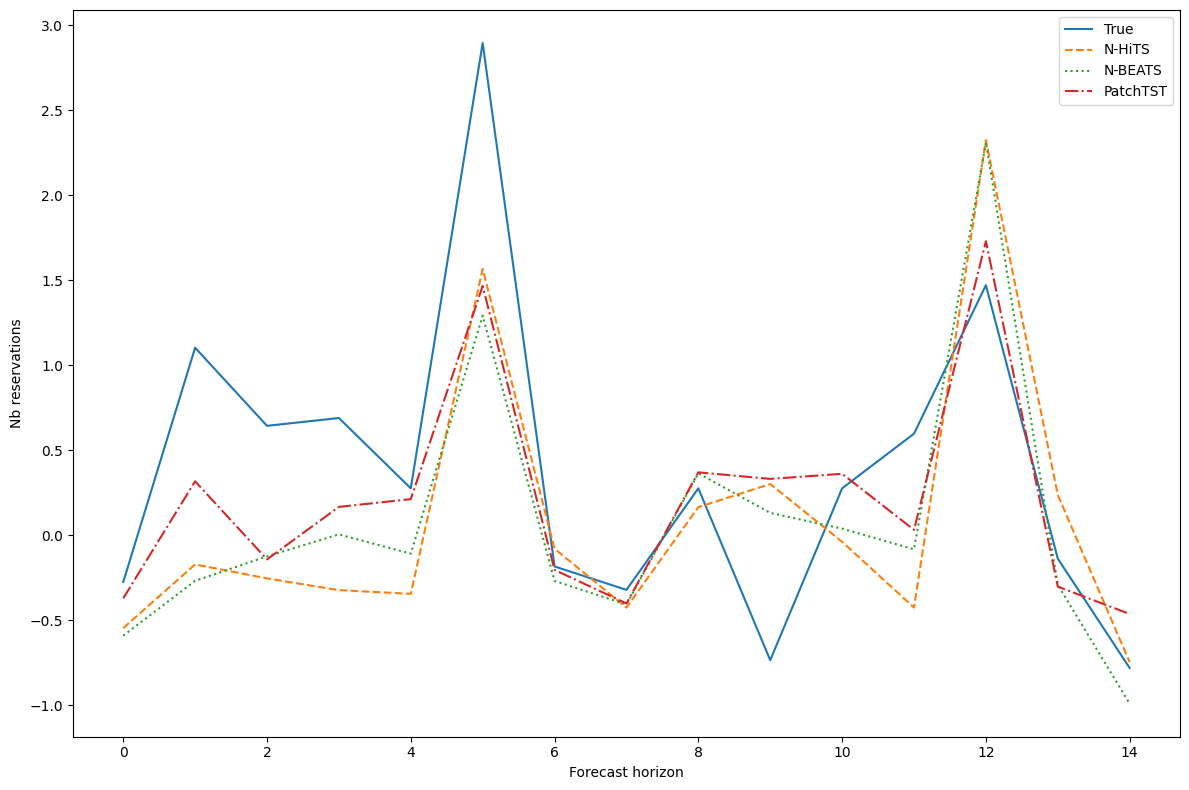

In [156]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(y_true[0, 0, :], label='True')
ax.plot(y_pred_nhits[0, 0, :], label='N-HiTS', ls='--')
ax.plot(y_pred_nbeats[0, 0, :], label='N-BEATS', ls=':')
ax.plot(y_pred_patchtst[0, 0, :], label='PatchTST', ls='-.')
ax.set_ylabel('Nb reservations')
ax.set_xlabel('Forecast horizon')
ax.legend(loc='best')

plt.tight_layout()

In [157]:
data = {'N-HiTS': [mae(y_pred_nhits, y_true), mse(y_pred_nhits, y_true)],
       'N-BEATS': [mae(y_pred_nbeats, y_true), mse(y_pred_nbeats, y_true)],
       'PatchTST': [mae(y_pred_patchtst, y_true), mse(y_pred_patchtst, y_true)]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,N-HiTS,N-BEATS,PatchTST
mae,0.486193,0.464069,0.475317
mse,0.393249,0.356273,0.360199
